In [2]:
import numpy as np
import pandas as pd
# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd. read_csv(r'D:\predictive maintenence\data\ai4i2020_final.csv')
df.columns

Index(['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'wear_z', 'mechanical_work'],
      dtype='object')

In [4]:
df = df.drop('wear_z', axis=1)

In [5]:
df.columns

Index(['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear',
       'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf', 'temp_diff',
       'heating_risk_scaled', 'power', 'mechanical_work'],
      dtype='object')

In [6]:
df['type'].head(2)

0    3
1    2
Name: type, dtype: int64


===== Evaluating: RAW features =====
Fold 1: F1 = 0.5185, PR-AUC = 0.5553, Best Threshold = 0.8467
Fold 2: F1 = 0.5370, PR-AUC = 0.5456, Best Threshold = 0.8332
Fold 3: F1 = 0.5098, PR-AUC = 0.5303, Best Threshold = 0.9269
Fold 4: F1 = 0.5607, PR-AUC = 0.5834, Best Threshold = 0.8965
Fold 5: F1 = 0.5347, PR-AUC = 0.5807, Best Threshold = 0.9155

===== Evaluating: FULL features =====
Fold 1: F1 = 0.8594, PR-AUC = 0.8663, Best Threshold = 0.8667
Fold 2: F1 = 0.8504, PR-AUC = 0.8837, Best Threshold = 0.9090
Fold 3: F1 = 0.8095, PR-AUC = 0.8351, Best Threshold = 0.5849
Fold 4: F1 = 0.8261, PR-AUC = 0.8340, Best Threshold = 0.6954
Fold 5: F1 = 0.8034, PR-AUC = 0.8458, Best Threshold = 0.8975

===== Summary =====

RAW Features:
F1 Score        : 0.5322 ± 0.0175
PR-AUC          : 0.5591 ± 0.0204
Best Thresholds : [0.8467 0.8332 0.9269 0.8965 0.9155]

FULL Features:
F1 Score        : 0.8298 ± 0.0220
PR-AUC          : 0.8530 ± 0.0192
Best Thresholds : [0.8667 0.909  0.5849 0.6954 0.8975]


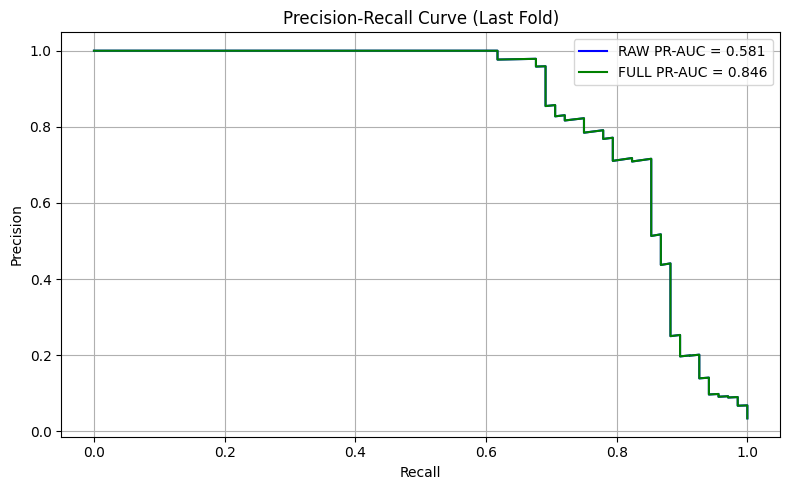

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


# Feature definitions
raw_features = ['type', 'process_temp', 'rot_speed', 'torque', 'tool_wear']
engineered = ['temp_diff', 'heating_risk_scaled', 'power', 'mechanical_work']
full_features = raw_features + engineered

X_raw = df[raw_features].values
X_full = df[full_features].values
y = df['machine_failure'].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {
    'raw': {'f1': [], 'pr_auc': [], 'best_thresholds': []},
    'full': {'f1': [], 'pr_auc': [], 'best_thresholds': []}
}

for label, X in [('raw', X_raw), ('full', X_full)]:
    print(f"\n===== Evaluating: {label.upper()} features =====")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

        model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight,
                              use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_val)[:, 1]

        # Find best threshold using F1
        precision, recall, thresholds = precision_recall_curve(y_val, probs)
        f1s = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)
        best_idx = np.argmax(f1s)
        best_thresh = thresholds[best_idx]
        best_f1 = f1s[best_idx]

        preds = (probs >= best_thresh).astype(int)
        pr_auc = average_precision_score(y_val, probs)

        # Store metrics
        metrics[label]['f1'].append(best_f1)
        metrics[label]['pr_auc'].append(pr_auc)
        metrics[label]['best_thresholds'].append(best_thresh)

        print(f"Fold {fold}: F1 = {best_f1:.4f}, PR-AUC = {pr_auc:.4f}, Best Threshold = {best_thresh:.4f}")

# Summary
print("\n===== Summary =====")
for label in ['raw', 'full']:
    print(f"\n{label.upper()} Features:")
    print(f"F1 Score        : {np.mean(metrics[label]['f1']):.4f} ± {np.std(metrics[label]['f1']):.4f}")
    print(f"PR-AUC          : {np.mean(metrics[label]['pr_auc']):.4f} ± {np.std(metrics[label]['pr_auc']):.4f}")
    print(f"Best Thresholds : {np.round(metrics[label]['best_thresholds'], 4)}")

# Optional: visualize last PR curves
plt.figure(figsize=(8, 5))
for label, color in zip(['raw', 'full'], ['blue', 'green']):
    precision, recall, _ = precision_recall_curve(y_val, probs if label=='full' else probs)
    plt.plot(recall, precision, label=f"{label.upper()} PR-AUC = {metrics[label]['pr_auc'][-1]:.3f}", color=color)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Last Fold)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


 98%|===================| 9759/10000 [00:19<00:00]        

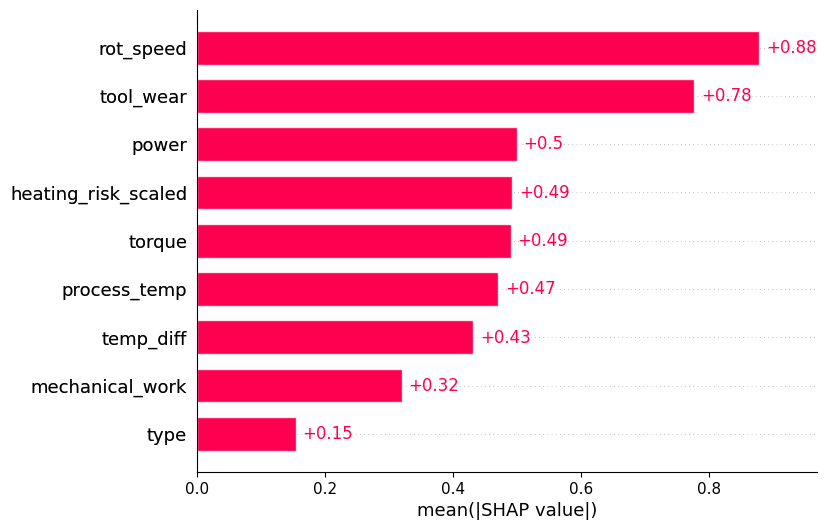

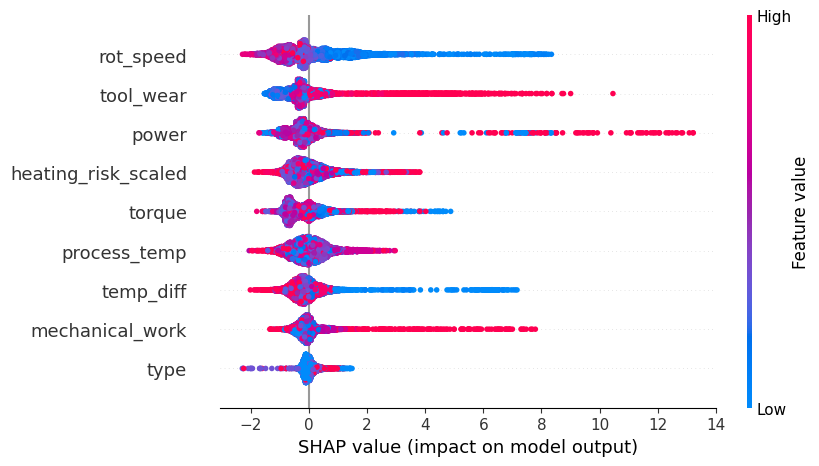

In [8]:
import shap

explainer = shap.Explainer(model, X_full, feature_names=full_features)
shap_values = explainer(X_full)

shap.plots.bar(shap_values, max_display=10)
shap.plots.beeswarm(shap_values, max_display=10)


In [9]:
import joblib

joblib.dump(model, r"D:\predictive maintenence\models\xgb_machine_failure_model.joblib")
joblib.dump(full_features, "features_used.joblib")
joblib.dump(0.79, "best_threshold.joblib")  # mean of best thresholds


['best_threshold.joblib']

In [10]:
failure_modes = ['twf', 'hdf', 'pwf', 'osf', 'rnf']
df[failure_modes].sum()
df[failure_modes].corr()


,twf,hdf,pwf,osf,rnf
twf,1.000000,-0.007332,0.008577,0.038243,0.030970
hdf,-0.007332,1.000000,0.018443,0.046396,-0.004706
pwf,0.008577,0.018443,1.000000,0.115836,-0.004273
osf,0.038243,0.046396,0.115836,1.000000,-0.004341
rnf,0.030970,-0.004706,-0.004273,-0.004341,1.000000


In [11]:
df['num_failures'] = df[['twf', 'hdf', 'pwf', 'osf', 'rnf']].sum(axis=1)
df['num_failures'].value_counts()


num_failures
0    9652
1     324
2      23
3       1
Name: count, dtype: int64

In [12]:
import numpy as np

# Assuming df is your DataFrame and 'tool_wear' & 'twf' are columns
wear_fail = df.loc[df['twf'] == 1, 'tool_wear'].values
print(f"Observed failure wear times: {wear_fail[:10]}… total {len(wear_fail)} points")


Observed failure wear times: [208 206 220 225 209 198 225 203 221 246]… total 46 points


In [13]:
from scipy.stats import weibull_min

# Force loc=0 (wear can’t be negative)
c, loc, lam = weibull_min.fit(wear_fail, floc=0)
print(f"Fitted Weibull parameters:\n  shape (k) = {c:.3f}\n  scale (lambda) = {lam:.1f}")


Fitted Weibull parameters:
  shape (k) = 16.041
  scale (lambda) = 222.5


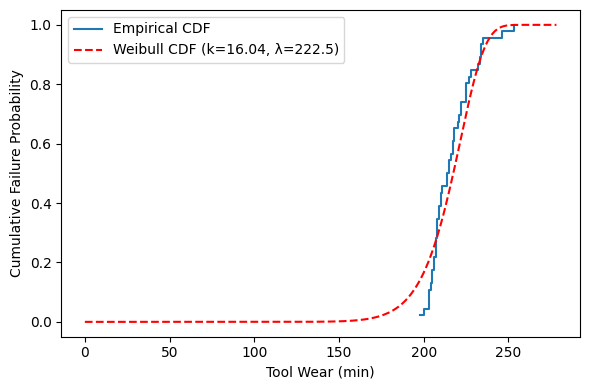

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Empirical CDF
sorted_wear = np.sort(wear_fail)
emp_cdf = np.arange(1, len(wear_fail)+1) / len(wear_fail)

# Weibull CDF
t = np.linspace(0, sorted_wear.max()*1.1, 200)
weib_cdf = weibull_min.cdf(t, c, loc=loc, scale=lam)

plt.figure(figsize=(6,4))
plt.step(sorted_wear, emp_cdf, where='post', label='Empirical CDF')
plt.plot(t, weib_cdf, 'r--', label=f'Weibull CDF (k={c:.2f}, λ={lam:.1f})')
plt.xlabel('Tool Wear (min)')
plt.ylabel('Cumulative Failure Probability')
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd
from scipy.stats import weibull_min
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    precision_recall_curve
)
from xgboost import XGBClassifier

# --- Assume df already preloaded ---
feature_cols = [
    'type','process_temp','rot_speed','torque','tool_wear',
    'temp_diff','heating_risk_scaled','power','mechanical_work'
]
modes = ['twf','hdf','pwf','osf','rnf']

X = df[feature_cols].values
Y = df[modes].values

# Outer split
outer_split = IterativeStratification(n_splits=2, order=1)
train_idx, test_idx = next(outer_split.split(X,Y))
X_train_full, Y_train_full = X[train_idx], Y[train_idx]
X_test,         Y_test       = X[test_idx],  Y[test_idx]

df_tr = pd.DataFrame(X_train_full, columns=feature_cols)
df_te = pd.DataFrame(X_test,        columns=feature_cols)
y_tr  = pd.DataFrame(Y_train_full,  columns=modes)
y_te  = pd.DataFrame(Y_test,        columns=modes)

# Inner CV to find best thresholds
inner_cv = IterativeStratification(n_splits=5, order=1)
best_thresholds = {m: [] for m in modes}

for tr_idx, val_idx in inner_cv.split(X_train_full, Y_train_full):
    X_tr, X_val = X_train_full[tr_idx], X_train_full[val_idx]
    y_tr_cv, y_val_cv = Y_train_full[tr_idx], Y_train_full[val_idx]
    df_tr_cv = pd.DataFrame(X_tr, columns=feature_cols)
    df_val_cv= pd.DataFrame(X_val, columns=feature_cols)
    y_tr_df  = pd.DataFrame(y_tr_cv, columns=modes)
    y_val_df = pd.DataFrame(y_val_cv, columns=modes)

    # TWF: Weibull
    wear_fail = df_tr_cv.loc[y_tr_df['twf']==1, 'tool_wear'].values
    k, loc, lam = weibull_min.fit(wear_fail, floc=0)
    risk_val = weibull_min.cdf(df_val_cv['tool_wear'], k, loc=loc, scale=lam)
    prec, rec, thr = precision_recall_curve(y_val_df['twf'], risk_val)
    f1s = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-8)
    best_thresholds['twf'].append(thr[np.argmax(f1s)])

    # Other modes: XGB
    for m in modes:
        if m == 'twf':
            continue
        ytr = y_tr_df[m]; yval = y_val_df[m]
        wpos = (ytr==0).sum() / (ytr==1).sum()
        model = XGBClassifier(
            random_state=42,
            scale_pos_weight=wpos,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        model.fit(df_tr_cv, ytr)
        probs = model.predict_proba(df_val_cv)[:,1]
        prec, rec, thr = precision_recall_curve(yval, probs)
        f1s = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-8)
        best_thresholds[m].append(thr[np.argmax(f1s)])

# Average thresholds
avg_thr = {m: np.mean(best_thresholds[m]) for m in modes}

# Final model training (in memory)
models = {}
thresholds = avg_thr.copy()

# TWF: Weibull
wear_fail_full = df_tr.loc[y_tr['twf']==1, 'tool_wear'].values
k_full, loc_full, lam_full = weibull_min.fit(wear_fail_full, floc=0)
twf_params = (k_full, loc_full, lam_full)

# Other modes
for m in modes:
    if m == 'twf':
        continue
    ytr = y_tr[m]
    wpos = (ytr==0).sum() / (ytr==1).sum()
    model = XGBClassifier(
        random_state=42,
        scale_pos_weight=wpos,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(df_tr, ytr)
    models[m] = model

# Evaluate on hold-out
for m in modes:
    print(f"\n--- {m.upper()} on Hold-Out ---")
    if m == 'twf':
        k, loc, lam = twf_params
        thr = thresholds['twf']
        proba = weibull_min.cdf(df_te['tool_wear'], k, loc=loc, scale=lam)
    else:
        model = models[m]
        thr = thresholds[m]
        proba = model.predict_proba(df_te)[:,1]

    preds = (proba >= thr).astype(int)
    print(f"Threshold={thr:.3f}, PR-AUC={average_precision_score(y_te[m], proba):.3f}")
    print(classification_report(y_te[m], preds, digits=4))



--- TWF on Hold-Out ---
Threshold=0.695, PR-AUC=0.080
              precision    recall  f1-score   support

           0     0.9956    0.9952    0.9954      4977
           1     0.0400    0.0435    0.0417        23

    accuracy                         0.9908      5000
   macro avg     0.5178    0.5193    0.5185      5000
weighted avg     0.9912    0.9908    0.9910      5000


--- HDF on Hold-Out ---
Threshold=0.760, PR-AUC=0.997
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996      4942
           1     0.9500    0.9828    0.9661        58

    accuracy                         0.9992      5000
   macro avg     0.9749    0.9911    0.9828      5000
weighted avg     0.9992    0.9992    0.9992      5000


--- PWF on Hold-Out ---
Threshold=0.929, PR-AUC=0.971
              precision    recall  f1-score   support

           0     0.9992    0.9984    0.9988      4952
           1     0.8462    0.9167    0.8800        48

    accuracy     


====== SHAP Explanation for HDF ======


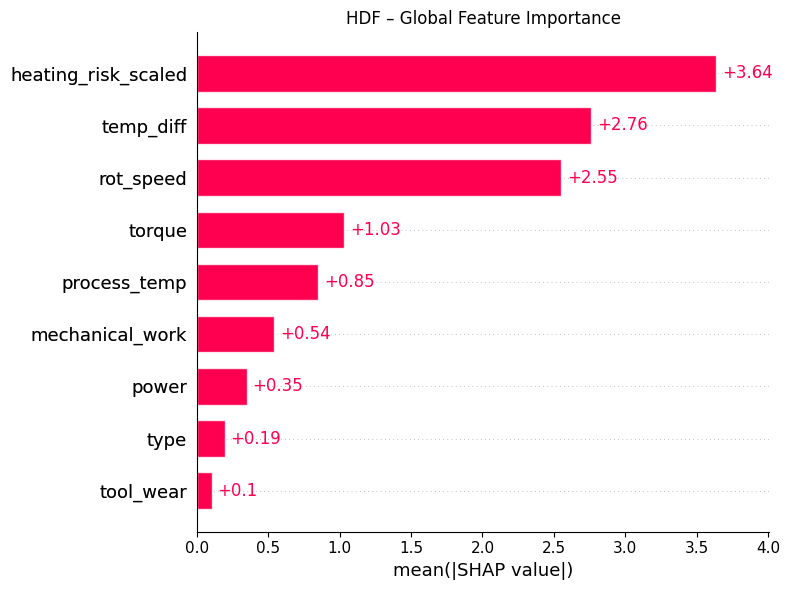

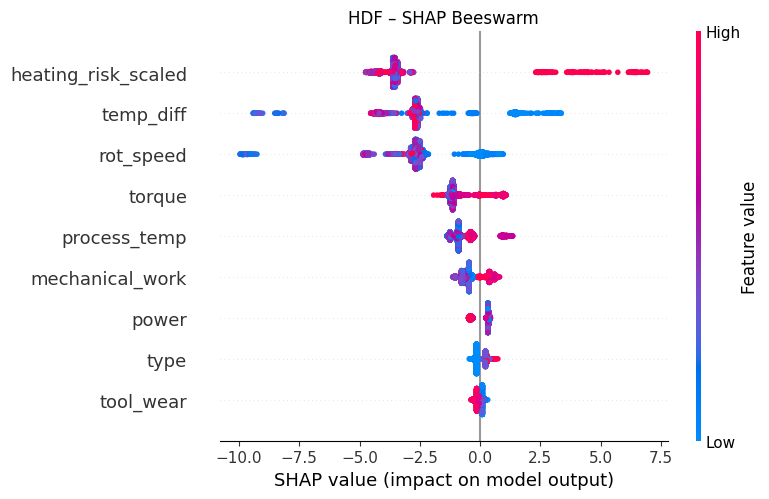

<Figure size 640x480 with 0 Axes>

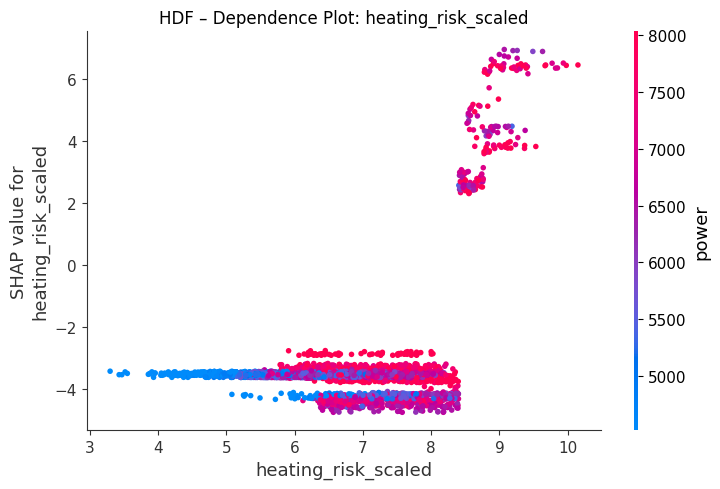

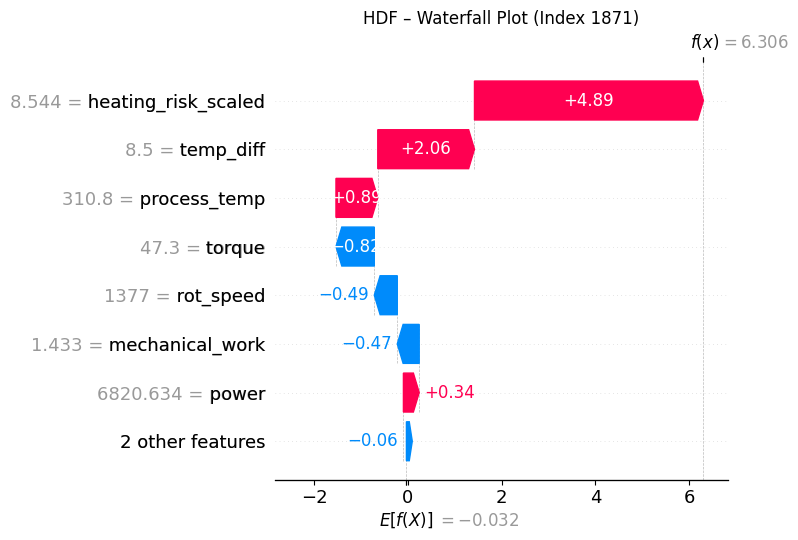


====== SHAP Explanation for PWF ======


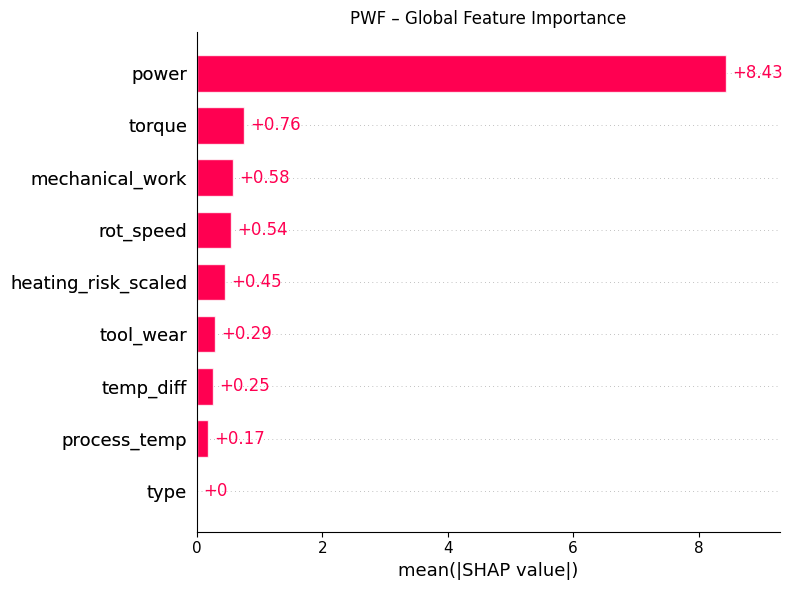

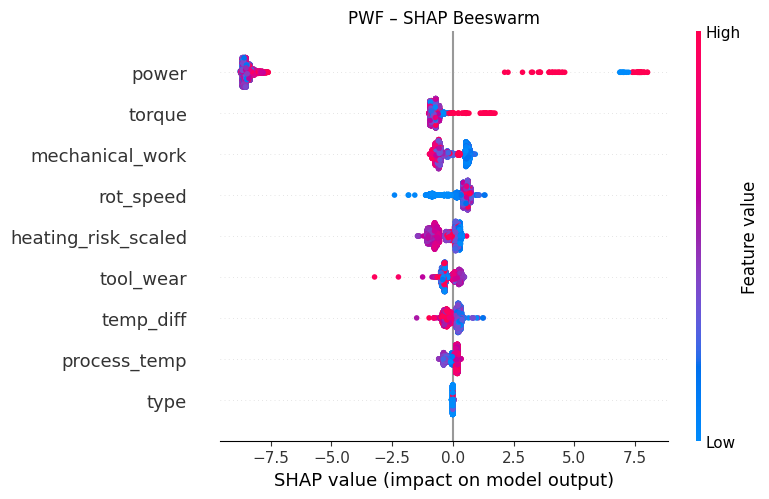

<Figure size 640x480 with 0 Axes>

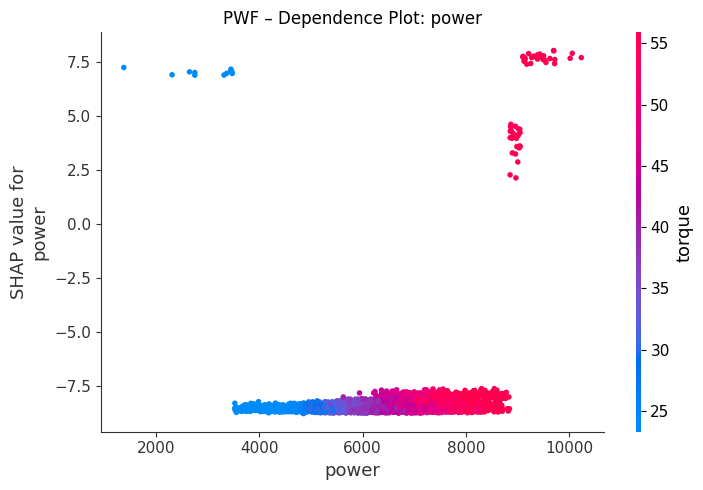

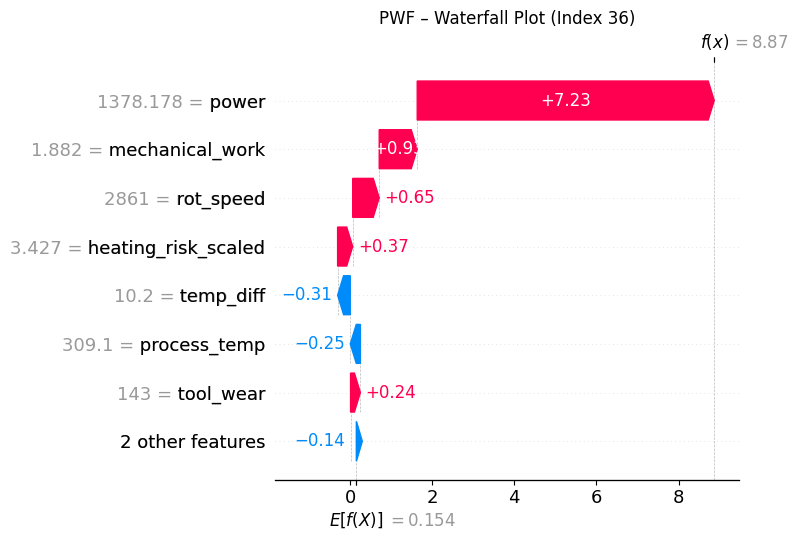


====== SHAP Explanation for OSF ======


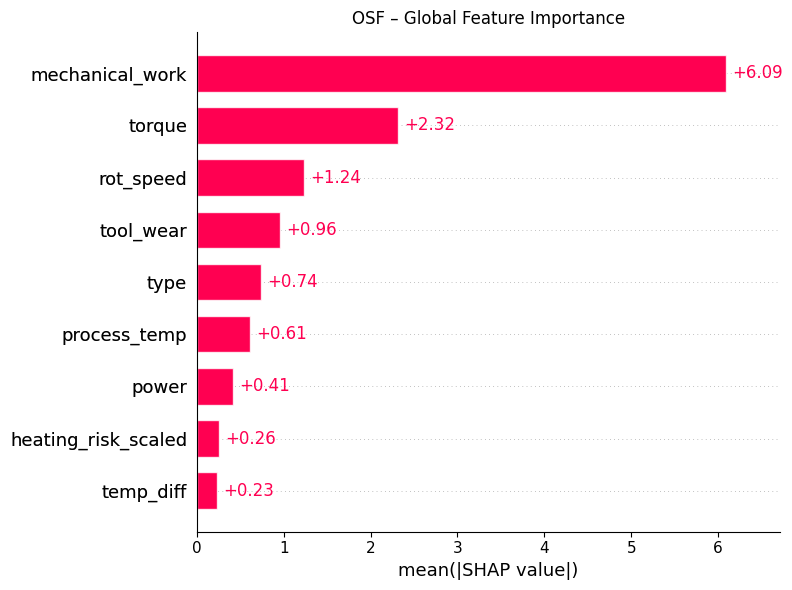

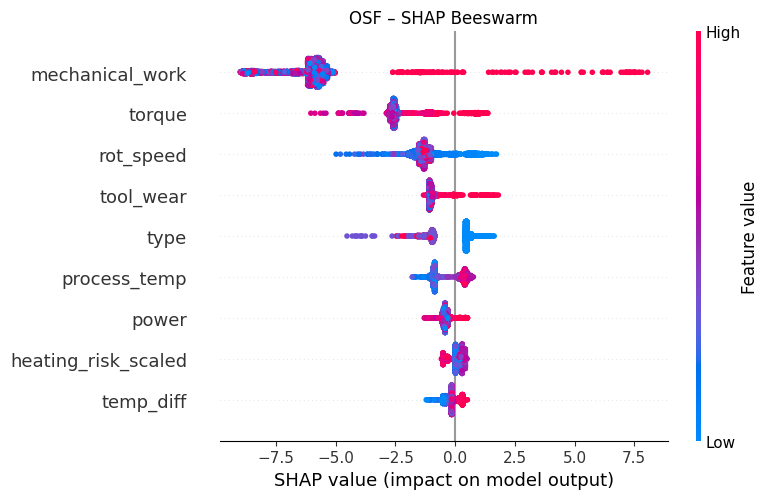

<Figure size 640x480 with 0 Axes>

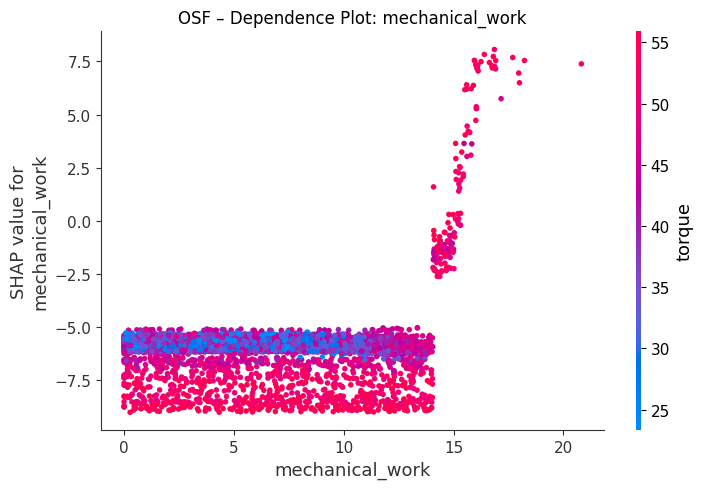

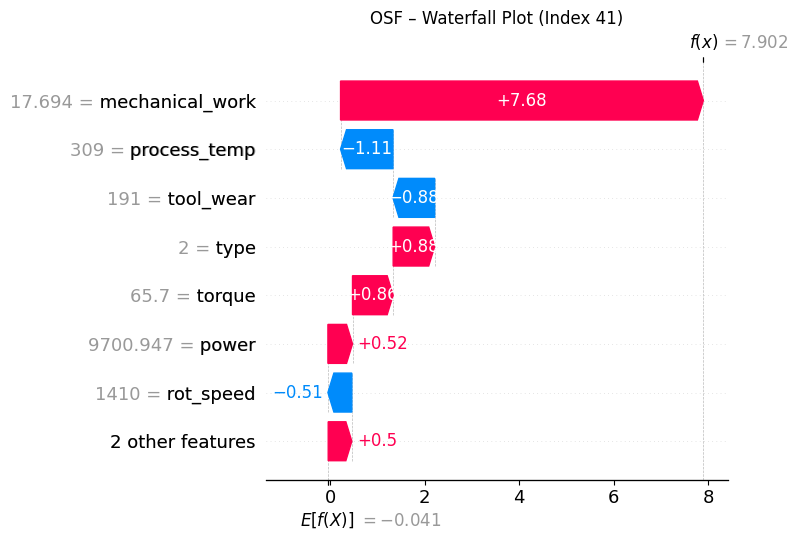

In [31]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Use same feature column list
feature_cols = [
    'type','process_temp','rot_speed','torque','tool_wear',
    'temp_diff','heating_risk_scaled','power','mechanical_work'
]

X_test = df_te[feature_cols]
y_test = y_te

# Only these modes have proper models
shap_modes = ['hdf', 'pwf', 'osf']

for mode in shap_modes:
    model = models[mode]
    threshold = thresholds[mode]

    print(f"\n====== SHAP Explanation for {mode.upper()} ======")

    # SHAP explainer for XGBoost
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    # === 1. Bar Plot ===
    plt.figure()
    shap.plots.bar(shap_values, max_display=10, show=False)
    plt.title(f"{mode.upper()} – Global Feature Importance")
    plt.tight_layout()
    plt.show()

    # === 2. Beeswarm Plot ===
    plt.figure()
    shap.plots.beeswarm(shap_values, max_display=10, show=False)
    plt.title(f"{mode.upper()} – SHAP Beeswarm")
    plt.tight_layout()
    plt.show()

    # === 3. Dependence Plot on Top Feature ===
    top_idx = np.abs(shap_values.values).mean(axis=0).argmax()
    top_feat = shap_values.feature_names[top_idx]

    plt.figure()
    shap.dependence_plot(
        top_feat, shap_values.values, X_test,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f"{mode.upper()} – Dependence Plot: {top_feat}")
    plt.tight_layout()
    plt.show()

    # === 4. Waterfall Plot: First True Positive ===
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= threshold).astype(int)
    idxs = np.where((y_test[mode].values == 1) & (preds == 1))[0]

    if len(idxs) == 0:
        print(f"  No true positives for {mode.upper()} to generate waterfall plot.")
        continue

    idx = idxs[0]
    plt.figure()
    shap.plots.waterfall(shap_values[idx], max_display=8, show=False)
    plt.title(f"{mode.upper()} – Waterfall Plot (Index {idx})")
    plt.tight_layout()
    plt.show()


In [17]:
df['type']

0       3
1       2
2       2
3       2
4       2
       ..
9995    3
9996    5
9997    3
9998    5
9999    3
Name: type, Length: 10000, dtype: int64

In [25]:
df['machine_failure'].value_counts()

machine_failure
0    9661
1     339
Name: count, dtype: int64